In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import utils, icnn_pytorch_adaptive as icnn_pytorch

In [409]:
ckpt_path = '../logs/hexner_train_R2_timestep_0.05/t_20/checkpoints_dir/model_final.pth'
model_2 = '../logs/hexner_train_R2_timestep_0.05/t_19/checkpoints_dir/model_final.pth'
activation = 'relu'

model = icnn_pytorch.SingleBVPNet(in_features=6, out_features=1, type=activation, mode='mlp', hidden_features=128, num_hidden_layers=2, dropout=0)
model2 = icnn_pytorch.SingleBVPNet(in_features=6, out_features=1, type=activation, mode='mlp', hidden_features=128, num_hidden_layers=2, dropout=0)

checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
c2 = torch.load(model_2, map_location=torch.device("cpu"))

try:
    model_weights = checkpoint['model']
except:
    model_weights = checkpoint

try:
    mw = c2['model']
except:
    mw = c2

model.load_state_dict(model_weights)
model2.load_state_dict(mw)
model.eval()
model2.eval()

SingleBVPNet(
  (net): FCBlock(
    (nl): ReLU(inplace=True)
    (net_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=5, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_zu_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_z_zu): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_yu_u)

SingleBVPNet(
  (net): FCBlock(
    (nl): ReLU(inplace=True)
    (net_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=5, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_zu_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_z_zu): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_yu_u)

In [410]:
X = torch.zeros((100, 5))
p_T = torch.linspace(0, 1, 100).reshape(-1, 1)

X = torch.cat((X, p_T), dim=1)

t_1 = 1
X[:, 0] = t_1 # time
X[:, 1] = 0. # x1
X[:, 2] = 0. # v1
X[:, 3] = 0. # x2
X[:, 4] = 0. # v2
X_in = {'coords': X}
v2 = model(X_in)['model_out'].detach().cpu().numpy()

In [411]:
## check min max value for t = T - delta t
delta_t = 0.05
V1 = []
t = t_1 - delta_t
actions = []
values = []
u_map = {-1: -1, 0: 0,  1: 1}
d_map = {-1: -1, 0: 0,  1: 1}
R1 = 1
R2 = 5
# X = torch.tensor([[t, delta_x, delta_v]], dtype=torch.float32)
for p in torch.linspace(0, 1, 100):
    X = torch.zeros((1, 5))
    X[:, 1] = 0.
    X[:, 2] = 0.
    X[:, 3] = 0.
    X[:, 4] = 0.
    p_T = torch.linspace(0, 1, 9).reshape(-1, 1)
    p_T[:, ] = p
    X_new = torch.from_numpy(utils.dynamics_3(X, 1, 1, DT=delta_t))
    X_new = torch.cat((torch.ones(X_new.shape[0], 1), X_new), dim=1)
    # X_new = np.array([utils.make_payoff(X_new[0, :], X_new[1, :])]).reshape(-1, X_new.shape[1])
    X_new = np.array([utils.make_payoff_3(X_new[0, :], X_new[1, :], X_new[2, :])]).reshape(-1, 5)
    X_new = torch.from_numpy(X_new.astype(np.float32))
    X = torch.cat((X_new, p_T), dim=1)
    X[:, 0] = t
    X_in = {'coords': X}
    value = model2(X_in)['model_out'].detach().cpu().numpy()
    # value = utils.final_value(X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, -1]).numpy()
    values.append(value)
    minmaxV = value.reshape(3, 3) + (delta_t * utils.get_running_payoff(list(u_map.values()), list(d_map.values()), R1, R2,
                                                                 tau=delta_t)).reshape(3, 3)
    V1.append(np.min(np.max(minmaxV, 1)))

In [412]:
p = p_T.numpy()
points = zip(V1, p)
from utils import cav_vex

In [413]:
ps = np.linspace(0, 1, 100)
vex = []
for p in ps:
    vex.append(cav_vex(V1, p, type='vex', num_ps=100))

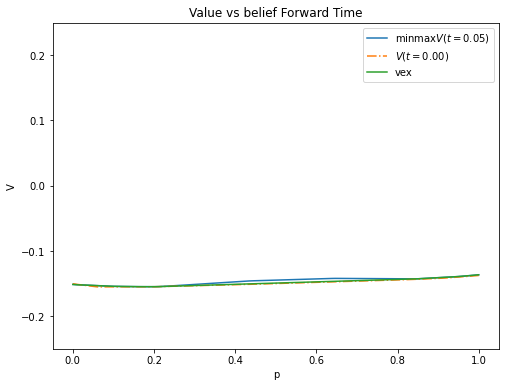

In [416]:
plt.plot(np.linspace(0, 1, 100), V1, label=f'$\min \max V(t={1 - t:.2f})$')
plt.plot(np.linspace(0, 1, 100), v2, '-.', label=f'$V(t={1-t-delta_t:.2f})$')
plt.plot(np.linspace(0, 1, 100), vex, label='vex')
plt.title('Value vs belief Forward Time')
plt.xlabel('p')
plt.ylabel('V')
plt.legend()
plt.ylim([-0.25, 0.25])
plt.rcParams['figure.figsize'] = (8, 6)

In [443]:
np.arange(0, 1.1, 0.25)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [405]:
up = 0.5
states = [up]
for _ in range(1):  # change to 9 for 10 timesteps
    states.append((states[-1] - 0.005) / 1.1)

In [406]:
states

[0.5, 0.44999999999999996]

In [415]:
t_step = int(0.5 * 100) // 2

In [603]:
t_step

25

In [575]:
np.linspace(0, 1, 3)

array([0. , 0.5, 1. ])

In [503]:
np.linspace(0, 1, 6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [593]:
t = np.arange(0.05, 1.05, 0.05)

In [657]:
t_step = int(np.where(t == 0.05)[0] + 1)
t_step

1

In [698]:
up = 0.5
states = [up]
for _ in range(9):  # change to 9 for 10 timesteps
    states.append((states[-1] - 0.005) / 1.1)

In [699]:
states

[0.5,
 0.44999999999999996,
 0.4045454545454545,
 0.3632231404958677,
 0.3256574004507888,
 0.2915067276825352,
 0.2604606615295774,
 0.23223696502688854,
 0.20657905911535318,
 0.1832536901048665]